# ATMS 523

## Module 4 Project

Submit this code as a pull request back to GitHub Classroom by the date and time listed in Canvas.

For this assignment, use the ERA-5 *monthly mean* data at NCAR (DOI: 10.5065/P8GT-0R61) as we did in Module 2.  Feel free to reduce the data to 1 degree resolution if you need to save data download times.


1) Create a dataset that contains the monthly means of Sea Surface Temperature anomalies and total column water vapor from Jan 1979-Dec 2024 over the Pacific Basin https://cds.climate.copernicus.eu/datasets/reanalysis-era5-single-levels-monthly-means?tab=download](https://cds.climate.copernicus.eu/datasets/reanalysis-era5-single-levels-monthly-means?tab=download)(65°N to 65°S, 120°E to 60°W) masked out over land - save this to your computer.

In [1]:
# Import necessary libraries

import numpy as np
import xarray as xr

from eofs.xarray import Eof
from eofs.examples import example_data_path

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from sklearn.preprocessing import StandardScaler

In [2]:
# Open ecmwf reanalysis data in xarray

ds = xr.open_dataset("reanlaysis_data2.nc", engine="netcdf4")
print(ds)

<xarray.Dataset> Size: 5GB
Dimensions:     (valid_time: 1020, latitude: 521, longitude: 721)
Coordinates:
    number      int64 8B ...
  * valid_time  (valid_time) datetime64[ns] 8kB 1940-01-01 ... 2024-12-01
  * latitude    (latitude) float64 4kB 65.0 64.75 64.5 ... -64.5 -64.75 -65.0
  * longitude   (longitude) float64 6kB -240.0 -239.8 -239.5 ... -60.25 -60.0
    expver      (valid_time) <U4 16kB ...
Data variables:
    sst         (valid_time, latitude, longitude) float32 2GB ...
    tcrw        (valid_time, latitude, longitude) float32 2GB ...
    tcwv        (valid_time, latitude, longitude) float32 2GB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-10-14T15:00 GRIB to CDM+CF via cfgrib-0.9.1...


In [3]:
# Step 1: Rename 'valid_time' to 'time' Note my data came through with
# 'valid_time' as the time dimension which was different than the example. Am renaming for consistency and use with provided functions.
ds = ds.rename({'valid_time': 'time'})


2)  From the dataset shown in 1, compute anomalies by deseasonalizing the data (remove the mean monthly anomaly from the annual mean from each point) and detrend the data. 


Then, standardize the SST anomalies.  Standardization means subtract the long term mean and divide by the standard deviation, which can be accomplished using the methods described here: [6.3. Preprocessing data &mdash; scikit-learn 1.1.2 documentation](https://scikit-learn.org/stable/modules/preprocessing.html)

In [ ]:
# Note worked with Copilot to come up with code to deasonalize and detrend SST specifically

# --- Load SST data ---
sst = ds['sst']  # monthly SST, dims: (time, latitude, longitude)

# --- Step 1: Deseasonalize (remove monthly climatology) ---
monthly_climatology = sst.groupby('time.month').mean('time')
sst_anom = sst.groupby('time.month') - monthly_climatology

# --- Step 2: Detrend each grid point ---
def detrend_ts(ts):
    x = np.arange(ts.size)
    mask = np.isfinite(ts)
    if mask.sum() < 2:
        return ts
    coeffs = np.polyfit(x[mask], ts[mask], deg=1)
    trend = np.polyval(coeffs, x)
    return ts - trend

sst_detrended = xr.apply_ufunc(
    detrend_ts,
    sst_anom,
    input_core_dims=[['time']],
    output_core_dims=[['time']],
    vectorize=True,
    dask='parallelized',
    output_dtypes=[sst.dtype]
)

# --- Step 3: Standardize using scikit-learn ---
# Reshape to (time, lat*lon)
flat = sst_detrended.stack(grid=('latitude', 'longitude')).transpose('time', 'grid')

# Apply StandardScaler
scaler = StandardScaler()
flat_scaled = xr.DataArray(
    scaler.fit_transform(flat),
    dims=flat.dims,
    coords=flat.coords
)

# Unstack back to original shape
sst_standardized = flat_scaled.unstack('grid')

# Optional: assign to dataset
ds['sst_standardized'] = sst_standardized

In [ ]:
# Extract SST from the deasonalized and detrended data
sst = sst_standardized

# Compute square-root of cosine latitude weights
coslat = np.cos(np.deg2rad(ds.coords['latitude'].values))
wgts = np.sqrt(coslat)[..., np.newaxis]  # shape: (lat, 1)

# Create EOF solver
solver = Eof(sst, weights=wgts)

c:\Users\jared\miniconda3\envs\xarray-climate\Lib\site-packages\dask\array\numpy_compat.py:57: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


In [ ]:
# Retrieve the leading EOF, expressed as the correlation between the leading
# PC time series and the input SST anomalies at each grid point, and the
# leading PC time series itself.

eof1 = solver.eofsAsCorrelation(neofs=2)
pc1 = solver.pcs(npcs=2, pcscaling=1)

2)  From the dataset shown in 1, compute anomalies by deseasonalizing the data (remove the mean monthly anomaly from the annual mean from each point) and detrend the data. 


Then, standardize the SST anomalies.  Standardization means subtract the long term mean and divide by the standard deviation, which can be accomplished using the methods described here: [6.3. Preprocessing data &mdash; scikit-learn 1.1.2 documentation](https://scikit-learn.org/stable/modules/preprocessing.html)

c:\Users\jared\miniconda3\envs\xarray-climate\Lib\site-packages\cartopy\mpl\feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


Text(0.5, 1.0, 'EOF1 expressed as correlation')

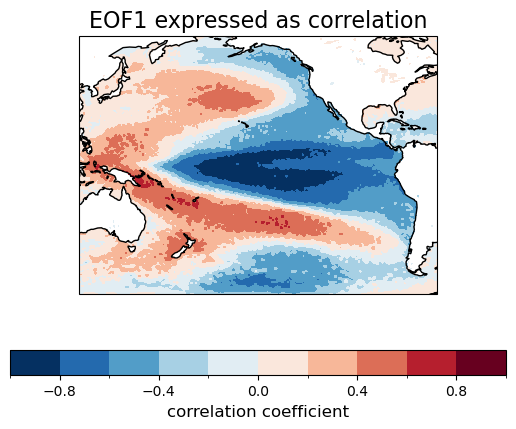

In [ ]:
# Plot the leading EOF expressed as correlation in the Pacific domain.
clevs = np.linspace(-1, 1, 11)
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=190))
fill = eof1[0].plot.contourf(ax=ax, levels=clevs, cmap=plt.cm.RdBu_r,
                             add_colorbar=False, transform=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE, color='k', edgecolor='k')
cb = plt.colorbar(fill, orientation='horizontal')
cb.set_label('correlation coefficient', fontsize=12)
ax.set_title('EOF1 expressed as correlation', fontsize=16)

In [ ]:
# Run pre-built function for converting time to numeric values. Taken from example notebook.

def _time_as_float(time: xr.DataArray, time_dim: str) -> xr.DataArray:
    # numeric seconds since first timestamp (keeps numbers small)
    return (time - time.isel({time_dim: 0})).astype("timedelta64[s]").astype("int64").astype("float64")

In [ ]:
# Run pre-built function for removing linear trend from data. Taken from example notebook.
def linear_detrend(obj: xr.DataArray | xr.Dataset, time_dim: str = "time") -> xr.DataArray | xr.Dataset:
    """
    Remove a linear trend y ~ s*(t - t̄_valid) + ȳ_valid at each grid point.
    Closed-form LS using reductions; dask-friendly; handles NaNs.
    """
    t = _time_as_float(obj[time_dim], time_dim)  # (time,)
    def _detrend_da(da: xr.DataArray) -> xr.DataArray:
        da = da.sortby(time_dim).astype("float32")
        if hasattr(da.data, "chunks"):
            da = da.chunk({time_dim: -1})  # one chunk along time
        mask = da.notnull()                                # (time, ...)
        t_b = t.broadcast_like(da)                         # (time, ...)
        t_mean_valid = t_b.where(mask).mean(time_dim, skipna=True)
        tc = t_b - t_mean_valid                            # centered time per point
        num = (da * tc).sum(time_dim, skipna=True)
        den = (tc**2).sum(time_dim, skipna=True)
        slope = xr.where(den > 0, num / den, 0.0)
        ybar  = da.mean(time_dim, skipna=True)
        trend = slope * (t_b - t_mean_valid) + ybar
        return (da - trend).astype("float32")
    return obj.map(_detrend_da) if isinstance(obj, xr.Dataset) else _detrend_da(obj)

In [ ]:
# Run pre-built function for removing monthly climatology and computing z-scores. Taken from example notebook.
def monthly_anom_and_z(
    detr: xr.DataArray | xr.Dataset,
    time_dim: str = "time",
    base_period: tuple[str, str] | None = None,
    ddof: int = 1,
    eps: float = 1e-6,
):
    """
    From linearly-detrended data, remove monthly climatology and compute monthly z-scores.
    Returns (anom, z). Works for Dataset or DataArray.
    """
    clim_src = detr if base_period is None else detr.sel({time_dim: slice(*base_period)})
    key = f"{time_dim}.month"

    clim_mean = clim_src.groupby(key).mean(time_dim, skipna=True)
    anom = detr.groupby(key) - clim_mean

    clim_std = clim_src.groupby(key).std(time_dim, skipna=True, ddof=ddof)
    safe_std = xr.where(clim_std > eps, clim_std, np.nan)
    z = anom.groupby(key) / safe_std
    return anom, z

In [ ]:
# Worked with Copilot to overcome memory errors using chunking. Modification from class example due to those issues I encountered.

# --- Step 0: Use preprocessed SST ---
# Assume you've already run the deseasonalize → detrend → standardize pipeline
# sst_standardized = ds['sst']  # shape: (time, latitude, longitude)

# --- Step 1: Chunk time dimension for performance ---
ds_chunked = sst_standardized.chunk({"time": -1})

# --- Step 2: Select other variables to preprocess (excluding SST) ---
vars_to_detrend = ["tcrw"]  # SST already preprocessed
ds_subset = ds[vars_to_detrend].chunk({"time": -1})  # no .to_dataset()

# --- Step 3: Apply linear detrending to other variables ---
detrended = linear_detrend(ds_subset, time_dim="time")

# --- Step 4: Compute monthly anomalies and z-scores for other variables ---
anom, z = monthly_anom_and_z(
    detrended,
    time_dim="time",
    base_period=("1981-01-01", "2010-12-31")
)

# --- Step 5: Add preprocessed SST to results ---
z['sst'] = sst_standardized
anom['sst'] = sst_standardized  # optional: if you want anomalies to match z-scores

# --- Step 6: Inspect results ---
print("Anomaly type:", type(anom), "Variables:", list(anom.data_vars))
print("Z-score type:", type(z), "Variables:", list(z.data_vars))

Anomaly type: <class 'xarray.core.dataset.Dataset'> Variables: ['tcrw', 'sst']
Z-score type: <class 'xarray.core.dataset.Dataset'> Variables: ['tcrw', 'sst']


In [ ]:
# Also modified the solver example due to memory issues encountered at several steps along the way.

# Use preprocessed SST anomalies
sst = sst_standardized  # dims: (time, latitude, longitude)

# Ensure correct dimension order
sst = sst.transpose('time', 'latitude', 'longitude')

# Create latitude weights
coslat = np.cos(np.deg2rad(sst['latitude']))
wgts = np.sqrt(coslat)

# Broadcast weights to match spatial grid
wgts_2d = wgts.broadcast_like(sst.isel(time=0))

# Create EOF solver
solver = Eof(sst, weights=wgts_2d)

3) Perform an EOF analysis on the SST anomalies and plot a map of the first 5 EOFs, following M04N05.

In [ ]:
# Note was encountering memory and visualization issues. Believe the issue was due to NaNs in the data. Worked with Copilot to mask those out.

# Step 1: Mask NaNs
sst_masked = sst_standardized.where(np.isfinite(sst), 0)

# Step 2: Compute weights with correct shape
coslat = np.cos(np.deg2rad(sst_masked.latitude))
wgts_2d = np.sqrt(coslat).broadcast_like(sst_masked.isel(time=0))

# Step 3: Chunk for memory safety
sst_masked = sst_masked.chunk({'time': -1, 'latitude': 50, 'longitude': 50})
wgts_2d = wgts_2d.chunk({'latitude': 50, 'longitude': 50})

# Step 4: Create EOF solver
solver = Eof(sst_masked, weights=wgts_2d)

c:\Users\jared\miniconda3\envs\xarray-climate\Lib\site-packages\dask\array\slicing.py:1029: PerformanceWarning: Increasing number of chunks by factor of 190
  p = blockwise(


c:\Users\jared\miniconda3\envs\xarray-climate\Lib\site-packages\dask\array\numpy_compat.py:57: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


c:\Users\jared\miniconda3\envs\xarray-climate\Lib\site-packages\cartopy\mpl\feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


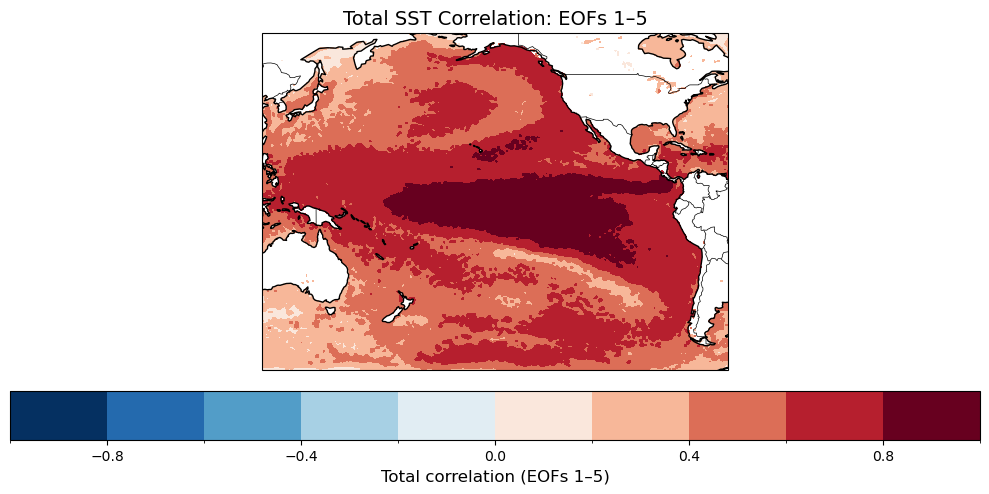

In [ ]:
# Note use of chunking to avoid / reduce the likelihood of memory issues per work with Copilot.

# Chunk arrays for memory efficiency
sst = sst.chunk({'time': -1, 'latitude': 50, 'longitude': 50})
eofs = solver.eofs(neofs=5).chunk({'mode': 1, 'latitude': 50, 'longitude': 50})
pcs = solver.pcs(npcs=5).chunk({'time': -1, 'mode': 1})

# Reconstruct SST using first 5 EOF modes with lazy summation
reconstructed = xr.zeros_like(sst)
for i in range(5):
    reconstructed += pcs.isel(mode=i).broadcast_like(eofs.isel(mode=i)) * eofs.isel(mode=i)
reconstructed = reconstructed.transpose('time', 'latitude', 'longitude')

# Compute Pearson correlation map
correlation_map = xr.corr(sst, reconstructed, dim='time')

# Convert longitudes to [0, 360] if needed
if (correlation_map.longitude < 0).any():
    correlation_map = correlation_map.assign_coords(
        longitude=((correlation_map.longitude + 360) % 360)
    )

# Mask to Pacific Basin: 120°E to 300°E
correlation_map = correlation_map.where(
    (correlation_map.longitude >= 120) & (correlation_map.longitude <= 300)
)

# Plot correlation map centered at -165.5°W
clevs = np.linspace(-1, 1, 11)
fig, ax = plt.subplots(figsize=(10, 5), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=-165.5)})
fill = correlation_map.plot.contourf(ax=ax, levels=clevs, cmap=plt.cm.RdBu_r,
                                     add_colorbar=False, transform=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE, color='k', edgecolor='k')
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
cb = plt.colorbar(fill, orientation='horizontal', pad=0.05)
cb.set_label('Total correlation (EOFs 1–5)', fontsize=12)
ax.set_title('Total SST Correlation: EOFs 1–5', fontsize=14)
plt.tight_layout()
plt.show()

4) Plot the percent of variance explained by the first 10 EOFs.

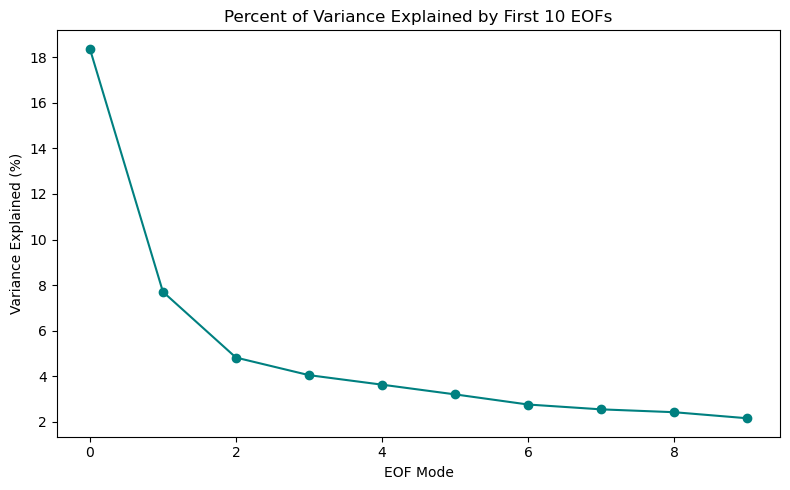

In [ ]:
# Get variance fraction for all modes
varfrac = solver.varianceFraction()

# Select first 10 modes and convert to percent
percent_var = varfrac.isel(mode=slice(10)) * 100

# Plot
plt.figure(figsize=(8, 5))
percent_var.plot(marker='o', color='teal')
plt.title('Percent of Variance Explained by First 10 EOFs')
plt.xlabel('EOF Mode')
plt.ylabel('Variance Explained (%)')
plt.grid(False)
plt.tight_layout()
plt.show()

5) Reconstruct the SST field using the first 5 EOFs and plot a map of the Pearson's correlation coefficient ([xarray.corr](https://docs.xarray.dev/en/stable/generated/xarray.corr.html)) of the reconstructed monthly time series and the "observed" SST time series.

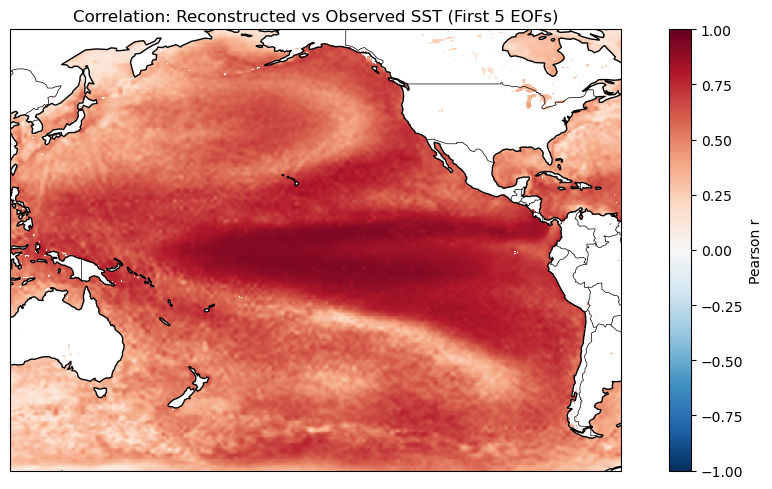

In [ ]:
# Note had to adjust ECMWF coordinates to the following -240W (in degrees east) to -60E. Kept 65N to -65S
# Extract first 5 EOFs and PCs
eofs = solver.eofs(neofs=5)       # (mode, lat, lon)
pcs = solver.pcs(npcs=5)          # (time, mode)

# Reconstruct SST using first 5 EOF modes
reconstructed = sum(
    pcs.isel(mode=i).broadcast_like(eofs.isel(mode=i)) * eofs.isel(mode=i)
    for i in range(5)
)

# Align dimensions
reconstructed = reconstructed.transpose('time', 'latitude', 'longitude')

# Compute Pearson correlation map
correlation_map = xr.corr(sst, reconstructed, dim='time')

# Convert longitudes to [0, 360] if needed
if (correlation_map.longitude < 0).any():
    correlation_map = correlation_map.assign_coords(
        longitude=((correlation_map.longitude + 360) % 360)
    )

# Mask to Pacific Basin: 120°E to 300°E
correlation_map = correlation_map.where(
    (correlation_map.longitude >= 120) & (correlation_map.longitude <= 300)
)

# Plot correlation map centered at -165.2°
projection = ccrs.PlateCarree(central_longitude=-165.2)
fig, ax = plt.subplots(figsize=(10, 5), subplot_kw={'projection': projection})
correlation_map.plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cmap='RdBu_r',
    vmin=-1,
    vmax=1,
    cbar_kwargs={'label': 'Pearson r'}
)
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.set_title('Correlation: Reconstructed vs Observed SST (First 5 EOFs)')
plt.tight_layout()
plt.show()

6) Compute a map of the Pearson's correlation coefficient between SST EOF1 and monthly mean detrended, deseasonalized, and standardized monthly mean column water vapor anomalies (don't mask these over land for the plot).  See anything interesting?

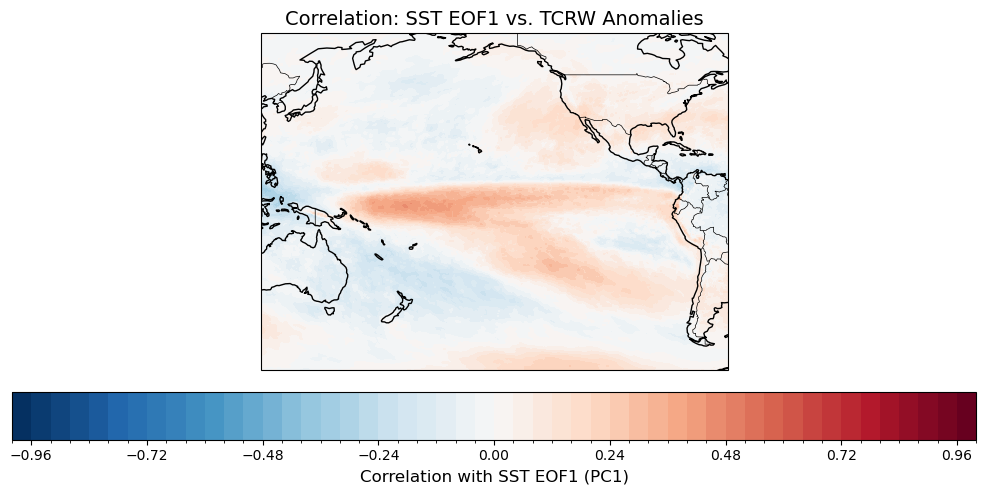

In [ ]:
# Worked with copilot on the following code block based on work done above. Note chunking to avoid memory issues.



# Step 0: Chunk TCRW along time for Dask parallelism
tcrw = ds['tcrw'].chunk({'time': 100})  # Adjust chunk size based on memory
tcrw = tcrw.transpose('time', 'latitude', 'longitude')

# Step 1: Extract PC1 and align
pc1 = pcs.sel(mode=0).chunk({'time': -1})  # Ensure it's chunked too
pc1.name = 'pc1'
tcrw, pc1 = xr.align(tcrw, pc1)

# Step 2: Compute correlation manually
pc1_mean = pc1.mean(dim='time')
tcrw_mean = tcrw.mean(dim='time')

pc1_anom = pc1 - pc1_mean
tcrw_anom = tcrw - tcrw_mean

numerator = (tcrw_anom * pc1_anom).mean(dim='time')
denominator = tcrw_anom.std(dim='time') * pc1_anom.std(dim='time')

correlation_map = numerator / denominator

# Step 3: Convert longitudes to [0, 360] if needed
if (correlation_map.longitude < 0).any():
    correlation_map = correlation_map.assign_coords(
        longitude=((correlation_map.longitude + 360) % 360)
    )

# Step 4: Mask to Pacific Basin
correlation_map = correlation_map.where(
    (correlation_map.longitude >= 120) & (correlation_map.longitude <= 300)
)

# Step 5: Plot
clevs = np.linspace(-1, 1, 51)
fig, ax = plt.subplots(figsize=(10, 5), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=-165.5)})

fill = correlation_map.plot.contourf(
    ax=ax, levels=clevs, cmap='RdBu_r', add_colorbar=False,
    transform=ccrs.PlateCarree()
)

ax.add_feature(cfeature.COASTLINE, edgecolor='k')
ax.add_feature(cfeature.BORDERS, linewidth=0.5)

cb = plt.colorbar(fill, orientation='horizontal', pad=0.05)
cb.set_label('Correlation with SST EOF1 (PC1)', fontsize=12)

ax.set_title('Correlation: SST EOF1 vs. TCRW Anomalies', fontsize=14)
plt.tight_layout()
plt.show()

The map above is interesting. It shows that where EOF1 is expressed as a correlation there are relationships in other areas. Focusing on the ENSO region and North America, there appears to be a pretty strong correlation between the ENSO and the effect on total column water vapor. Strongest in the ENSO region, but also notable in North America.